# Two-qubit States Reconstruction

In [1]:
import numpy as np
import scipy as sp
import scipy.linalg
import matplotlib.pyplot as plt
import qiskit as qk
import qiskit.visualization

from qiskit import Aer
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import Statevector

from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit import transpile
from qiskit.quantum_info.operators import Operator

from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import depolarizing_error
from qiskit.providers.aer.noise import amplitude_damping_error
from qiskit.providers.aer.noise import kraus_error

import tensorflow as tf
print("TensorFlow version:", tf.__version__)
from tensorflow.python.framework.ops import convert_to_tensor

TensorFlow version: 2.11.0


In [27]:
#Ensure reproducibility
np.random.seed(123)
tf.random.set_seed(123)
import random
random.seed(10)

## Data Generation

In [2]:
# Generation of a random unitary transformation
def random_unitary(N):
    Z=np.random.randn(N,N) + 1.0j * np.random.randn(N,N)
    [Q,R]=sp.linalg.qr(Z)
    D=np.diag(np.diagonal(R)/np.abs(np.diagonal(R)))
    return np.dot(Q,D)

In [3]:
#Function which generates the density matrix given the state vector
def get_density_matrix(state_vector):
    density_matrix = np.outer(state_vector, np.conjugate(state_vector))
    return density_matrix

In [4]:
#Function which computes the components of the Bloch vector, given the density matrix 

#Here we define the identity matrix and the Pauli matrices for dimension 2 (one qubit)
I = np.array([[1, 0],[0, 1]])
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])

def Bloch_vector(rho):
    ax = np.trace(np.dot(rho, X)).real
    ay = np.trace(np.dot(rho, Y)).real
    az = np.trace(np.dot(rho, Z)).real
    pnt = [ax, ay, az]
    return pnt

In [5]:
#Function to represent the data on the Bloch sphere

def Bloch_sphere(data):
    fig = plt.figure(figsize=(8, 8))
    ax = plt.subplot(projection='3d')
    qk.visualization.plot_bloch_vector([0, 0, 0], title='Bloch Sphere',ax=ax)
    for (x, y, z) in data:
        ax.scatter3D(y, -x, z, c='b') #here x and y axis are inverted in order to match qiskit and matplotlib axis
        #ax.plot(y, -x, z, marker='.', c='b', alpha=0.7)

In [6]:
#Choice of simulator
sim_bknd=Aer.get_backend('aer_simulator')

In [7]:
def generate_Haar_data(num_qubits, samples=1000):
    data = []
    for i in range(samples):
        qc = qk.QuantumCircuit(num_qubits) #creates a quantum circuit with "num_qubits" qubits
        u = random_unitary(2**num_qubits)
        qc.unitary(u, qubits=range(num_qubits)) #applies the random unitary transformation to the circuit
        qc = qk.transpile(qc, backend=sim_bknd) #it's used to optimize the circuit
        qc.save_statevector() #it's the instruction to save the state vector obtained by the simulation

        state = sim_bknd.run(qc).result().get_statevector(qc) #does the simulation and gets the state vector
        state = np.asarray(state)
        data.append(state) 
    return data

## Useful Functions

In [16]:
pauli_basis1q = np.array([I, X, Y, Z])
pauli_basis2q = np.array([np.kron(a,b) for a in pauli_basis1q for b in pauli_basis1q])
pauli_basis2q_modified = pauli_basis2q[1:]

#function which returns bloch components from density matrix
def bloch_coeffs(rho):
    c = []
    for p in pauli_basis2q_modified:
        c.append(np.trace(rho @ p))
    return np.array(c)

In [29]:
I_4 = tf.constant([[1.0, 0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0]],shape=(4,4), dtype = tf.complex64)
def fid_twoq(a,b):
   a = tf.cast(a, tf.complex64)
   b = tf.cast(b, tf.complex64)
   el_a = tf.einsum('ijk,mi->mjk', pauli_basis2q_modified, a)
   el_b = tf.einsum('ijk,mi->mjk', pauli_basis2q_modified, b)
   rho_a = 0.25 *(el_a + I_4)
   rho_b = 0.25 * (el_b +I_4)
   fidelity = tf.linalg.trace(tf.linalg.sqrtm(tf.linalg.sqrtm(rho_a) @ rho_b @ tf.linalg.sqrtm(rho_a))) **2
   return fidelity 

## Noise Model

In [8]:
#num_qubits = 1

#PROBABILITIES FOR BIT, PHASE, BIT-PHASE FLIP OR DEPOLARIZING CHANNELS
p_error = 0.2
    
#PROBABILITIES FOR GENERAL PAULI CHANNEL
p_0=0.7
p_1=0.2
p_2=0.05
p_3=0.05
    
#PARAMETERS FOR KRAUS CHANNEL
alpha = np.pi / 3
beta = np.pi / 6
    
A_0 = np.array([[np.cos (alpha), 0], [0, np.cos (beta)]])
A_1 = np.array([[0, np.sin (beta)], [np.sin (alpha), 0]])
Kraus_operators = [A_0, A_1]
    
bit_flip_error = pauli_error([('X', p_error), ('I', 1 - p_error)])
phase_flip_error = pauli_error([('Z', p_error), ('I', 1 - p_error)])
bit_phase_flip_error = pauli_error([('Y', p_error), ('I', 1 - p_error)])
#dep_error = depolarizing_error(p_error, num_qubits)
general_pauli_error = pauli_error([('X', p_1), ('Y', p_2), ('Z', p_3), ('I', p_0)])
AD_error = amplitude_damping_error (0.3, 0.5) 
k_error = kraus_error(Kraus_operators)

In [9]:
#applies NOISE whenever an identity gate appears in the circuit (compatibly with the channels parameters)
def qsk_add_error(error_type):
    if error_type == 'bit':
        noise_model.add_all_qubit_quantum_error(bit_flip_error, ["id"])
    if error_type == 'phase':
        noise_model.add_all_qubit_quantum_error(phase_flip_error, ["id"])
    if error_type == 'bit-phase':
        noise_model.add_all_qubit_quantum_error(bit_phase_flip_error, ["id"])
    if error_type == 'depolarizing':
        noise_model.add_all_qubit_quantum_error(dep_error, ["id"])
    if error_type == 'Gpauli':
        noise_model.add_all_qubit_quantum_error(general_pauli_error, ["id"])
    if error_type == 'AD':
        noise_model.add_all_qubit_quantum_error(AD_error, ["id"])
    if error_type == 'Kraus':
        noise_model.add_all_qubit_quantum_error(k_error, ["id"])

##  <font color='green'>Training the Algorithm (MSE)</font>

### <font color='green'>Different Channels on both Qubits</font>

In [13]:
# Generate data
data = generate_Haar_data(2, 1000) #each state_vector has 4 elements
density_matrix_noise_free = [*map(get_density_matrix, data)] #16 components for each density matrix

In [14]:
#Apply Noise
num_qubits = 2
den_mat_noise_free = []
den_mat_with_noise = []


for i in range(len(data)):

    circ = qk.QuantumCircuit(num_qubits) 

    circ.initialize(data[i])
    circ = transpile(circ, backend=Aer.get_backend('aer_simulator_density_matrix')) 
    circ.barrier()
    circ.id(0) #applies identity to the first qubit
    circ.id(1) #applies identity to the second qubit
    circ.save_density_matrix()
    #print(circ)
    ideal_bknd = AerSimulator()
    res = ideal_bknd.run(circ).result().data()['density_matrix'] #simulates the circuit and saves the density matrix obtained
    den_noise_free = np.asarray(res)
    den_mat_noise_free.append(den_noise_free)


    noise_model = NoiseModel()
    noise_model.add_quantum_error(phase_flip_error, ["id"], [0])
    noise_model.add_quantum_error(bit_flip_error, ["id"], [1])
    noisy_bknd = AerSimulator(method = 'density_matrix', noise_model=noise_model)
    res_noise = noisy_bknd.run(circ).result().data()['density_matrix']
    den_with_noise = np.asarray(res_noise)
    den_mat_with_noise.append(den_with_noise)

In [17]:
vectors_noise_free = [*map(bloch_coeffs, den_mat_noise_free)]
vectors_with_noise = [*map(bloch_coeffs, den_mat_with_noise)]

In [42]:
x_train_list = vectors_with_noise[:300]
y_train_list = vectors_noise_free[:300]

x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)

x_val_list = vectors_with_noise[400:800]
y_val_list = vectors_noise_free[400:800]

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test_list = vectors_with_noise[800:]
y_test_list = vectors_noise_free[800:]

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

In [43]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(15,)),   
  tf.keras.layers.Dense(64, activation='relu'),                                 
  tf.keras.layers.Dense(64, activation='relu'), 
  tf.keras.layers.Dense(15)
  ])

In [44]:
# Define Loss
loss_fn = tf.keras.losses.mse
# Compile model
adam_opt = tf.optimizers.Adam(0.001)
model.compile(optimizer=adam_opt,
              loss=loss_fn)

In [45]:
# Train Model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=50, epochs=500)

Epoch 1/500
6/6 [==============================] - 2s 68ms/step - loss: 0.2011 - val_loss: 0.1896
Epoch 2/500
6/6 [==============================] - 0s 23ms/step - loss: 0.1852 - val_loss: 0.1768
Epoch 3/500
6/6 [==============================] - 0s 26ms/step - loss: 0.1720 - val_loss: 0.1649
Epoch 4/500
6/6 [==============================] - 0s 24ms/step - loss: 0.1594 - val_loss: 0.1532
Epoch 5/500
6/6 [==============================] - 0s 21ms/step - loss: 0.1469 - val_loss: 0.1412
Epoch 6/500
6/6 [==============================] - 0s 19ms/step - loss: 0.1342 - val_loss: 0.1289
Epoch 7/500
6/6 [==============================] - 0s 23ms/step - loss: 0.1212 - val_loss: 0.1165
Epoch 8/500
6/6 [==============================] - 0s 20ms/step - loss: 0.1083 - val_loss: 0.1043
Epoch 9/500
6/6 [==============================] - 0s 21ms/step - loss: 0.0954 - val_loss: 0.0922
Epoch 10/500
6/6 [==============================] - 0s 21ms/step - loss: 0.0832 - val_loss: 0.0808
Epoch 11/500
6/6 [=

Epoch 84/500
6/6 [==============================] - 0s 20ms/step - loss: 0.0013 - val_loss: 0.0027
Epoch 85/500
6/6 [==============================] - 0s 19ms/step - loss: 0.0013 - val_loss: 0.0027
Epoch 86/500
6/6 [==============================] - 0s 18ms/step - loss: 0.0013 - val_loss: 0.0027
Epoch 87/500
6/6 [==============================] - 0s 24ms/step - loss: 0.0013 - val_loss: 0.0026
Epoch 88/500
6/6 [==============================] - 0s 27ms/step - loss: 0.0012 - val_loss: 0.0026
Epoch 89/500
6/6 [==============================] - 0s 26ms/step - loss: 0.0012 - val_loss: 0.0026
Epoch 90/500
6/6 [==============================] - 0s 23ms/step - loss: 0.0012 - val_loss: 0.0026
Epoch 91/500
6/6 [==============================] - 0s 19ms/step - loss: 0.0012 - val_loss: 0.0026
Epoch 92/500
6/6 [==============================] - 0s 19ms/step - loss: 0.0012 - val_loss: 0.0025
Epoch 93/500
6/6 [==============================] - 0s 21ms/step - loss: 0.0012 - val_loss: 0.0025
Epoch 94/5

Epoch 164/500
6/6 [==============================] - 0s 21ms/step - loss: 5.6328e-04 - val_loss: 0.0015
Epoch 165/500
6/6 [==============================] - 0s 24ms/step - loss: 5.5633e-04 - val_loss: 0.0015
Epoch 166/500
6/6 [==============================] - 0s 24ms/step - loss: 5.4511e-04 - val_loss: 0.0015
Epoch 167/500
6/6 [==============================] - 0s 23ms/step - loss: 5.4137e-04 - val_loss: 0.0015
Epoch 168/500
6/6 [==============================] - 0s 24ms/step - loss: 5.4021e-04 - val_loss: 0.0015
Epoch 169/500
6/6 [==============================] - 0s 23ms/step - loss: 5.3328e-04 - val_loss: 0.0015
Epoch 170/500
6/6 [==============================] - 0s 22ms/step - loss: 5.3157e-04 - val_loss: 0.0015
Epoch 171/500
6/6 [==============================] - 0s 23ms/step - loss: 5.3489e-04 - val_loss: 0.0015
Epoch 172/500
6/6 [==============================] - 0s 25ms/step - loss: 5.2146e-04 - val_loss: 0.0015
Epoch 173/500
6/6 [==============================] - 0s 24ms/ste

Epoch 243/500
6/6 [==============================] - 0s 24ms/step - loss: 3.2221e-04 - val_loss: 0.0011
Epoch 244/500
6/6 [==============================] - 0s 24ms/step - loss: 3.2327e-04 - val_loss: 0.0011
Epoch 245/500
6/6 [==============================] - 0s 27ms/step - loss: 3.2282e-04 - val_loss: 0.0011
Epoch 246/500
6/6 [==============================] - 0s 27ms/step - loss: 3.2016e-04 - val_loss: 0.0011
Epoch 247/500
6/6 [==============================] - 0s 26ms/step - loss: 3.2531e-04 - val_loss: 0.0011
Epoch 248/500
6/6 [==============================] - 0s 25ms/step - loss: 3.2297e-04 - val_loss: 0.0011
Epoch 249/500
6/6 [==============================] - 0s 24ms/step - loss: 3.1946e-04 - val_loss: 0.0011
Epoch 250/500
6/6 [==============================] - 0s 24ms/step - loss: 3.2311e-04 - val_loss: 0.0011
Epoch 251/500
6/6 [==============================] - 0s 24ms/step - loss: 3.1847e-04 - val_loss: 0.0010
Epoch 252/500
6/6 [==============================] - 0s 24ms/ste

Epoch 320/500
6/6 [==============================] - 0s 19ms/step - loss: 2.1555e-04 - val_loss: 8.3848e-04
Epoch 321/500
6/6 [==============================] - 0s 19ms/step - loss: 2.1352e-04 - val_loss: 8.3062e-04
Epoch 322/500
6/6 [==============================] - 0s 19ms/step - loss: 2.1575e-04 - val_loss: 8.3800e-04
Epoch 323/500
6/6 [==============================] - 0s 24ms/step - loss: 2.1643e-04 - val_loss: 8.2766e-04
Epoch 324/500
6/6 [==============================] - 0s 21ms/step - loss: 2.1424e-04 - val_loss: 8.2898e-04
Epoch 325/500
6/6 [==============================] - 0s 20ms/step - loss: 2.1698e-04 - val_loss: 8.4647e-04
Epoch 326/500
6/6 [==============================] - 0s 28ms/step - loss: 2.1199e-04 - val_loss: 8.4079e-04
Epoch 327/500
6/6 [==============================] - 0s 25ms/step - loss: 2.1257e-04 - val_loss: 8.3835e-04
Epoch 328/500
6/6 [==============================] - 0s 26ms/step - loss: 2.1665e-04 - val_loss: 8.3935e-04
Epoch 329/500
6/6 [=========

Epoch 396/500
6/6 [==============================] - 0s 23ms/step - loss: 1.5804e-04 - val_loss: 7.1327e-04
Epoch 397/500
6/6 [==============================] - 0s 23ms/step - loss: 1.5962e-04 - val_loss: 6.8856e-04
Epoch 398/500
6/6 [==============================] - 0s 22ms/step - loss: 1.5625e-04 - val_loss: 6.9232e-04
Epoch 399/500
6/6 [==============================] - 0s 23ms/step - loss: 1.5402e-04 - val_loss: 6.9400e-04
Epoch 400/500
6/6 [==============================] - 0s 22ms/step - loss: 1.5927e-04 - val_loss: 6.9193e-04
Epoch 401/500
6/6 [==============================] - 0s 23ms/step - loss: 1.6504e-04 - val_loss: 7.0188e-04
Epoch 402/500
6/6 [==============================] - 0s 22ms/step - loss: 1.5882e-04 - val_loss: 6.8875e-04
Epoch 403/500
6/6 [==============================] - 0s 21ms/step - loss: 1.5906e-04 - val_loss: 6.8660e-04
Epoch 404/500
6/6 [==============================] - 0s 20ms/step - loss: 1.6099e-04 - val_loss: 6.9732e-04
Epoch 405/500
6/6 [=========

Epoch 472/500
6/6 [==============================] - 0s 19ms/step - loss: 1.1813e-04 - val_loss: 5.8169e-04
Epoch 473/500
6/6 [==============================] - 0s 22ms/step - loss: 1.1530e-04 - val_loss: 5.7696e-04
Epoch 474/500
6/6 [==============================] - 0s 21ms/step - loss: 1.1493e-04 - val_loss: 5.7139e-04
Epoch 475/500
6/6 [==============================] - 0s 22ms/step - loss: 1.1448e-04 - val_loss: 5.7928e-04
Epoch 476/500
6/6 [==============================] - 0s 20ms/step - loss: 1.1835e-04 - val_loss: 5.7299e-04
Epoch 477/500
6/6 [==============================] - 0s 19ms/step - loss: 1.1789e-04 - val_loss: 5.7420e-04
Epoch 478/500
6/6 [==============================] - 0s 20ms/step - loss: 1.2252e-04 - val_loss: 5.6787e-04
Epoch 479/500
6/6 [==============================] - 0s 21ms/step - loss: 1.1958e-04 - val_loss: 5.7619e-04
Epoch 480/500
6/6 [==============================] - 0s 22ms/step - loss: 1.1559e-04 - val_loss: 5.7986e-04
Epoch 481/500
6/6 [=========

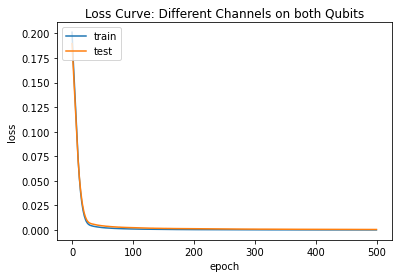

In [46]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Curve: Different Channels on both Qubits')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [47]:
score = model.evaluate(x_test,  y_test, verbose=2)

7/7 - 0s - loss: 5.1106e-04 - 233ms/epoch - 33ms/step


In [48]:
#save the model predictions in a tensor
y_prediction = model(x_test)
y_prediction = y_prediction.numpy().tolist()

y_test = tf.cast(y_test, dtype=tf.float32)
x_test = tf.cast(x_test, dtype=tf.float32)


fid = fid_twoq(y_prediction, y_test)

fid_diff_mse = tf.math.reduce_mean(fid)
print(fid_diff_mse)

tf.Tensor((0.99558264-3.248299e-05j), shape=(), dtype=complex64)


### <font color='green'>Same Channel on both Qubits</font>

In [59]:
# Generate data
data = generate_Haar_data(2, 1000) #each state_vector has 4 elements
density_matrix_noise_free = [*map(get_density_matrix, data)] #16 components for each density matrix

In [60]:
#Apply Noise
num_qubits = 2
den_mat_noise_free = []
den_mat_with_noise = []


for i in range(len(data)):

    circ = qk.QuantumCircuit(num_qubits) 

    circ.initialize(data[i])
    circ = transpile(circ, backend=Aer.get_backend('aer_simulator_density_matrix')) 
    circ.barrier()
    circ.id(0) #applies identity to the first qubit
    circ.id(1) #applies identity to the second qubit
    circ.save_density_matrix()

    ideal_bknd = AerSimulator()
    res = ideal_bknd.run(circ).result().data()['density_matrix'] #simulates the circuit and saves the density matrix obtained
    den_noise_free = np.asarray(res)
    den_mat_noise_free.append(den_noise_free)


    noise_model = NoiseModel()
    noise_model.add_quantum_error(phase_flip_error, ["id"], [0])
    noise_model.add_quantum_error(phase_flip_error, ["id"], [1])
    noisy_bknd = AerSimulator(method = 'density_matrix', noise_model=noise_model)
    res_noise = noisy_bknd.run(circ).result().data()['density_matrix']
    den_with_noise = np.asarray(res_noise)
    den_mat_with_noise.append(den_with_noise)

In [61]:
vectors_noise_free = [*map(bloch_coeffs, den_mat_noise_free)]
vectors_with_noise = [*map(bloch_coeffs, den_mat_with_noise)]

In [82]:
x_train_list = vectors_with_noise[:300]
y_train_list = vectors_noise_free[:300]

x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)

x_val_list = vectors_with_noise[400:800]
y_val_list = vectors_noise_free[400:800]

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test_list = vectors_with_noise[800:]
y_test_list = vectors_noise_free[800:]

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

In [83]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(15,)),   
  tf.keras.layers.Dense(64, activation='relu'),                                 
  tf.keras.layers.Dense(64, activation='relu'), 
  tf.keras.layers.Dense(15)
  ])

In [84]:
# Define Loss
loss_fn = tf.keras.losses.mse
# Compile model
adam_opt = tf.optimizers.Adam(0.0008)
model.compile(optimizer=adam_opt,
              loss=loss_fn)

In [85]:
# Train Model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=50, epochs=500)

Epoch 1/500
6/6 [==============================] - 2s 64ms/step - loss: 0.2055 - val_loss: 0.1970
Epoch 2/500
6/6 [==============================] - 0s 20ms/step - loss: 0.1918 - val_loss: 0.1869
Epoch 3/500
6/6 [==============================] - 0s 20ms/step - loss: 0.1811 - val_loss: 0.1785
Epoch 4/500
6/6 [==============================] - 0s 24ms/step - loss: 0.1717 - val_loss: 0.1709
Epoch 5/500
6/6 [==============================] - 0s 26ms/step - loss: 0.1630 - val_loss: 0.1633
Epoch 6/500
6/6 [==============================] - 0s 26ms/step - loss: 0.1545 - val_loss: 0.1556
Epoch 7/500
6/6 [==============================] - 0s 20ms/step - loss: 0.1459 - val_loss: 0.1476
Epoch 8/500
6/6 [==============================] - 0s 18ms/step - loss: 0.1371 - val_loss: 0.1394
Epoch 9/500
6/6 [==============================] - 0s 21ms/step - loss: 0.1282 - val_loss: 0.1310
Epoch 10/500
6/6 [==============================] - 0s 21ms/step - loss: 0.1192 - val_loss: 0.1225
Epoch 11/500
6/6 [=

Epoch 84/500
6/6 [==============================] - 0s 23ms/step - loss: 0.0017 - val_loss: 0.0030
Epoch 85/500
6/6 [==============================] - 0s 23ms/step - loss: 0.0016 - val_loss: 0.0030
Epoch 86/500
6/6 [==============================] - 0s 24ms/step - loss: 0.0016 - val_loss: 0.0029
Epoch 87/500
6/6 [==============================] - 0s 22ms/step - loss: 0.0016 - val_loss: 0.0029
Epoch 88/500
6/6 [==============================] - 0s 22ms/step - loss: 0.0016 - val_loss: 0.0029
Epoch 89/500
6/6 [==============================] - 0s 22ms/step - loss: 0.0015 - val_loss: 0.0029
Epoch 90/500
6/6 [==============================] - 0s 21ms/step - loss: 0.0015 - val_loss: 0.0028
Epoch 91/500
6/6 [==============================] - 0s 19ms/step - loss: 0.0015 - val_loss: 0.0028
Epoch 92/500
6/6 [==============================] - 0s 18ms/step - loss: 0.0015 - val_loss: 0.0028
Epoch 93/500
6/6 [==============================] - 0s 20ms/step - loss: 0.0015 - val_loss: 0.0027
Epoch 94/5

6/6 [==============================] - 0s 24ms/step - loss: 6.9639e-04 - val_loss: 0.0016
Epoch 165/500
6/6 [==============================] - 0s 24ms/step - loss: 6.9748e-04 - val_loss: 0.0016
Epoch 166/500
6/6 [==============================] - 0s 24ms/step - loss: 6.9644e-04 - val_loss: 0.0016
Epoch 167/500
6/6 [==============================] - 0s 24ms/step - loss: 6.8228e-04 - val_loss: 0.0016
Epoch 168/500
6/6 [==============================] - 0s 24ms/step - loss: 6.7868e-04 - val_loss: 0.0016
Epoch 169/500
6/6 [==============================] - 0s 21ms/step - loss: 6.7675e-04 - val_loss: 0.0015
Epoch 170/500
6/6 [==============================] - 0s 21ms/step - loss: 6.6625e-04 - val_loss: 0.0016
Epoch 171/500
6/6 [==============================] - 0s 24ms/step - loss: 6.6070e-04 - val_loss: 0.0015
Epoch 172/500
6/6 [==============================] - 0s 22ms/step - loss: 6.6532e-04 - val_loss: 0.0016
Epoch 173/500
6/6 [==============================] - 0s 18ms/step - loss: 6.65

Epoch 243/500
6/6 [==============================] - 0s 19ms/step - loss: 4.0672e-04 - val_loss: 0.0011
Epoch 244/500
6/6 [==============================] - 0s 19ms/step - loss: 4.0840e-04 - val_loss: 0.0011
Epoch 245/500
6/6 [==============================] - 0s 20ms/step - loss: 4.0752e-04 - val_loss: 0.0011
Epoch 246/500
6/6 [==============================] - 0s 23ms/step - loss: 4.0646e-04 - val_loss: 0.0011
Epoch 247/500
6/6 [==============================] - 0s 26ms/step - loss: 4.0348e-04 - val_loss: 0.0011
Epoch 248/500
6/6 [==============================] - 0s 21ms/step - loss: 3.9861e-04 - val_loss: 0.0011
Epoch 249/500
6/6 [==============================] - 0s 21ms/step - loss: 3.9969e-04 - val_loss: 0.0011
Epoch 250/500
6/6 [==============================] - 0s 19ms/step - loss: 3.9066e-04 - val_loss: 0.0011
Epoch 251/500
6/6 [==============================] - 0s 22ms/step - loss: 3.8840e-04 - val_loss: 0.0010
Epoch 252/500
6/6 [==============================] - 0s 24ms/ste

6/6 [==============================] - 0s 20ms/step - loss: 2.8176e-04 - val_loss: 8.3156e-04
Epoch 320/500
6/6 [==============================] - 0s 21ms/step - loss: 2.8416e-04 - val_loss: 8.3507e-04
Epoch 321/500
6/6 [==============================] - 0s 23ms/step - loss: 2.7147e-04 - val_loss: 8.0458e-04
Epoch 322/500
6/6 [==============================] - 0s 23ms/step - loss: 2.6557e-04 - val_loss: 7.9549e-04
Epoch 323/500
6/6 [==============================] - 0s 24ms/step - loss: 2.6531e-04 - val_loss: 8.1977e-04
Epoch 324/500
6/6 [==============================] - 0s 23ms/step - loss: 2.6877e-04 - val_loss: 8.0952e-04
Epoch 325/500
6/6 [==============================] - 0s 23ms/step - loss: 2.7372e-04 - val_loss: 8.0933e-04
Epoch 326/500
6/6 [==============================] - 0s 23ms/step - loss: 2.7361e-04 - val_loss: 7.9228e-04
Epoch 327/500
6/6 [==============================] - 0s 22ms/step - loss: 2.5943e-04 - val_loss: 7.9019e-04
Epoch 328/500
6/6 [=======================

Epoch 395/500
6/6 [==============================] - 0s 23ms/step - loss: 1.9244e-04 - val_loss: 6.3420e-04
Epoch 396/500
6/6 [==============================] - 0s 24ms/step - loss: 1.8735e-04 - val_loss: 6.3327e-04
Epoch 397/500
6/6 [==============================] - 0s 23ms/step - loss: 1.9039e-04 - val_loss: 6.3001e-04
Epoch 398/500
6/6 [==============================] - 0s 22ms/step - loss: 1.9090e-04 - val_loss: 6.3447e-04
Epoch 399/500
6/6 [==============================] - 0s 22ms/step - loss: 1.8989e-04 - val_loss: 6.2729e-04
Epoch 400/500
6/6 [==============================] - 0s 23ms/step - loss: 1.8706e-04 - val_loss: 6.3072e-04
Epoch 401/500
6/6 [==============================] - 0s 23ms/step - loss: 1.9393e-04 - val_loss: 6.2570e-04
Epoch 402/500
6/6 [==============================] - 0s 25ms/step - loss: 1.8901e-04 - val_loss: 6.2701e-04
Epoch 403/500
6/6 [==============================] - 0s 23ms/step - loss: 1.9002e-04 - val_loss: 6.3472e-04
Epoch 404/500
6/6 [=========

Epoch 471/500
6/6 [==============================] - 0s 22ms/step - loss: 1.4376e-04 - val_loss: 5.3450e-04
Epoch 472/500
6/6 [==============================] - 0s 24ms/step - loss: 1.4299e-04 - val_loss: 5.2712e-04
Epoch 473/500
6/6 [==============================] - 0s 26ms/step - loss: 1.4386e-04 - val_loss: 5.3307e-04
Epoch 474/500
6/6 [==============================] - 0s 26ms/step - loss: 1.4719e-04 - val_loss: 5.2735e-04
Epoch 475/500
6/6 [==============================] - 0s 22ms/step - loss: 1.4217e-04 - val_loss: 5.1779e-04
Epoch 476/500
6/6 [==============================] - 0s 20ms/step - loss: 1.3775e-04 - val_loss: 5.2000e-04
Epoch 477/500
6/6 [==============================] - 0s 20ms/step - loss: 1.3841e-04 - val_loss: 5.3119e-04
Epoch 478/500
6/6 [==============================] - 0s 20ms/step - loss: 1.4139e-04 - val_loss: 5.1759e-04
Epoch 479/500
6/6 [==============================] - 0s 26ms/step - loss: 1.4023e-04 - val_loss: 5.1892e-04
Epoch 480/500
6/6 [=========

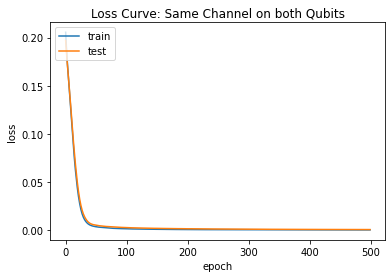

In [86]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Curve: Same Channel on both Qubits')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [87]:
score = model.evaluate(x_test,  y_test, verbose=2)

7/7 - 0s - loss: 5.5021e-04 - 292ms/epoch - 42ms/step


In [88]:
#save the model predictions in a tensor
y_prediction = model(x_test)
y_prediction = y_prediction.numpy().tolist()

y_test = tf.cast(y_test, dtype=tf.float32)
x_test = tf.cast(x_test, dtype=tf.float32)


fid = fid_twoq(y_prediction, y_test)

fid_same_mse = tf.math.reduce_mean(fid)
print(fid_same_mse)

tf.Tensor((0.9929829-2.3192393e-05j), shape=(), dtype=complex64)


### <font color='green'>One Channel on One Qubit</font>

In [89]:
# Generate data
data = generate_Haar_data(2, 1000) #each state_vector has 4 elements
density_matrix_noise_free = [*map(get_density_matrix, data)] #16 components for each density matrix

In [90]:
#Apply Noise
num_qubits = 2
den_mat_noise_free = []
den_mat_with_noise = []


for i in range(len(data)):

    circ = qk.QuantumCircuit(num_qubits) 

    circ.initialize(data[i])
    circ = transpile(circ, backend=Aer.get_backend('aer_simulator_density_matrix')) 
    circ.barrier()
    circ.id(0) #applies identity to the first qubit
    circ.id(1) #applies identity to the second qubit
    circ.save_density_matrix()

    ideal_bknd = AerSimulator()
    res = ideal_bknd.run(circ).result().data()['density_matrix'] #simulates the circuit and saves the density matrix obtained
    den_noise_free = np.asarray(res)
    den_mat_noise_free.append(den_noise_free)


    noise_model = NoiseModel()
    noise_model.add_quantum_error(phase_flip_error, ["id"], [0])
    noisy_bknd = AerSimulator(method = 'density_matrix', noise_model=noise_model)
    res_noise = noisy_bknd.run(circ).result().data()['density_matrix']
    den_with_noise = np.asarray(res_noise)
    den_mat_with_noise.append(den_with_noise)

In [91]:
vectors_noise_free = [*map(bloch_coeffs, den_mat_noise_free)]
vectors_with_noise = [*map(bloch_coeffs, den_mat_with_noise)]

In [92]:
x_train_list = vectors_with_noise[:300]
y_train_list = vectors_noise_free[:300]

x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)

x_val_list = vectors_with_noise[400:800]
y_val_list = vectors_noise_free[400:800]

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test_list = vectors_with_noise[800:]
y_test_list = vectors_noise_free[800:]

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

In [93]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(15,)),   
  tf.keras.layers.Dense(64, activation='relu'),                                 
  tf.keras.layers.Dense(64, activation='relu'), 
  tf.keras.layers.Dense(15)
  ])

In [94]:
# Define Loss
loss_fn = tf.keras.losses.mse
# Compile model
adam_opt = tf.optimizers.Adam(0.001)
model.compile(optimizer=adam_opt,
              loss=loss_fn)

In [95]:
# Train Model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=50, epochs=500)

Epoch 1/500
6/6 [==============================] - 2s 104ms/step - loss: 0.2172 - val_loss: 0.2079
Epoch 2/500
6/6 [==============================] - 0s 25ms/step - loss: 0.1970 - val_loss: 0.1927
Epoch 3/500
6/6 [==============================] - 0s 29ms/step - loss: 0.1823 - val_loss: 0.1804
Epoch 4/500
6/6 [==============================] - 0s 24ms/step - loss: 0.1693 - val_loss: 0.1692
Epoch 5/500
6/6 [==============================] - 0s 20ms/step - loss: 0.1574 - val_loss: 0.1584
Epoch 6/500
6/6 [==============================] - 0s 22ms/step - loss: 0.1453 - val_loss: 0.1472
Epoch 7/500
6/6 [==============================] - 0s 21ms/step - loss: 0.1329 - val_loss: 0.1355
Epoch 8/500
6/6 [==============================] - 0s 20ms/step - loss: 0.1202 - val_loss: 0.1237
Epoch 9/500
6/6 [==============================] - 0s 20ms/step - loss: 0.1075 - val_loss: 0.1119
Epoch 10/500
6/6 [==============================] - 0s 20ms/step - loss: 0.0951 - val_loss: 0.1001
Epoch 11/500
6/6 [

Epoch 84/500
6/6 [==============================] - 0s 26ms/step - loss: 0.0015 - val_loss: 0.0036
Epoch 85/500
6/6 [==============================] - 0s 23ms/step - loss: 0.0015 - val_loss: 0.0036
Epoch 86/500
6/6 [==============================] - 0s 22ms/step - loss: 0.0014 - val_loss: 0.0036
Epoch 87/500
6/6 [==============================] - 0s 19ms/step - loss: 0.0014 - val_loss: 0.0036
Epoch 88/500
6/6 [==============================] - 0s 19ms/step - loss: 0.0014 - val_loss: 0.0035
Epoch 89/500
6/6 [==============================] - 0s 22ms/step - loss: 0.0014 - val_loss: 0.0035
Epoch 90/500
6/6 [==============================] - 0s 20ms/step - loss: 0.0014 - val_loss: 0.0035
Epoch 91/500
6/6 [==============================] - 0s 20ms/step - loss: 0.0014 - val_loss: 0.0035
Epoch 92/500
6/6 [==============================] - 0s 24ms/step - loss: 0.0013 - val_loss: 0.0034
Epoch 93/500
6/6 [==============================] - 0s 25ms/step - loss: 0.0013 - val_loss: 0.0034
Epoch 94/5

6/6 [==============================] - 0s 18ms/step - loss: 7.2225e-04 - val_loss: 0.0024
Epoch 165/500
6/6 [==============================] - 0s 20ms/step - loss: 7.2030e-04 - val_loss: 0.0024
Epoch 166/500
6/6 [==============================] - 0s 20ms/step - loss: 7.1501e-04 - val_loss: 0.0024
Epoch 167/500
6/6 [==============================] - 0s 20ms/step - loss: 7.0423e-04 - val_loss: 0.0024
Epoch 168/500
6/6 [==============================] - 0s 20ms/step - loss: 7.0062e-04 - val_loss: 0.0024
Epoch 169/500
6/6 [==============================] - 0s 20ms/step - loss: 6.9682e-04 - val_loss: 0.0024
Epoch 170/500
6/6 [==============================] - 0s 23ms/step - loss: 6.8191e-04 - val_loss: 0.0024
Epoch 171/500
6/6 [==============================] - 0s 20ms/step - loss: 6.7973e-04 - val_loss: 0.0024
Epoch 172/500
6/6 [==============================] - 0s 20ms/step - loss: 6.8547e-04 - val_loss: 0.0023
Epoch 173/500
6/6 [==============================] - 0s 20ms/step - loss: 6.86

Epoch 243/500
6/6 [==============================] - 0s 20ms/step - loss: 4.6793e-04 - val_loss: 0.0020
Epoch 244/500
6/6 [==============================] - 0s 21ms/step - loss: 4.7099e-04 - val_loss: 0.0020
Epoch 245/500
6/6 [==============================] - 0s 23ms/step - loss: 4.5931e-04 - val_loss: 0.0019
Epoch 246/500
6/6 [==============================] - 0s 24ms/step - loss: 4.5792e-04 - val_loss: 0.0019
Epoch 247/500
6/6 [==============================] - 0s 23ms/step - loss: 4.6000e-04 - val_loss: 0.0020
Epoch 248/500
6/6 [==============================] - 0s 22ms/step - loss: 4.5844e-04 - val_loss: 0.0019
Epoch 249/500
6/6 [==============================] - 0s 21ms/step - loss: 4.5579e-04 - val_loss: 0.0019
Epoch 250/500
6/6 [==============================] - 0s 23ms/step - loss: 4.5352e-04 - val_loss: 0.0019
Epoch 251/500
6/6 [==============================] - 0s 19ms/step - loss: 4.4875e-04 - val_loss: 0.0019
Epoch 252/500
6/6 [==============================] - 0s 20ms/ste

Epoch 322/500
6/6 [==============================] - 0s 21ms/step - loss: 3.4175e-04 - val_loss: 0.0018
Epoch 323/500
6/6 [==============================] - 0s 20ms/step - loss: 3.4307e-04 - val_loss: 0.0017
Epoch 324/500
6/6 [==============================] - 0s 21ms/step - loss: 3.3705e-04 - val_loss: 0.0018
Epoch 325/500
6/6 [==============================] - 0s 21ms/step - loss: 3.3365e-04 - val_loss: 0.0017
Epoch 326/500
6/6 [==============================] - 0s 20ms/step - loss: 3.3258e-04 - val_loss: 0.0017
Epoch 327/500
6/6 [==============================] - 0s 19ms/step - loss: 3.2911e-04 - val_loss: 0.0017
Epoch 328/500
6/6 [==============================] - 0s 18ms/step - loss: 3.3512e-04 - val_loss: 0.0017
Epoch 329/500
6/6 [==============================] - 0s 18ms/step - loss: 3.4332e-04 - val_loss: 0.0018
Epoch 330/500
6/6 [==============================] - 0s 18ms/step - loss: 3.4200e-04 - val_loss: 0.0017
Epoch 331/500
6/6 [==============================] - 0s 18ms/ste

Epoch 401/500
6/6 [==============================] - 0s 25ms/step - loss: 2.6856e-04 - val_loss: 0.0016
Epoch 402/500
6/6 [==============================] - 0s 26ms/step - loss: 2.6650e-04 - val_loss: 0.0016
Epoch 403/500
6/6 [==============================] - 0s 23ms/step - loss: 2.7180e-04 - val_loss: 0.0016
Epoch 404/500
6/6 [==============================] - 0s 23ms/step - loss: 2.6643e-04 - val_loss: 0.0016
Epoch 405/500
6/6 [==============================] - 0s 18ms/step - loss: 2.6331e-04 - val_loss: 0.0016
Epoch 406/500
6/6 [==============================] - 0s 20ms/step - loss: 2.6754e-04 - val_loss: 0.0016
Epoch 407/500
6/6 [==============================] - 0s 22ms/step - loss: 2.6503e-04 - val_loss: 0.0016
Epoch 408/500
6/6 [==============================] - 0s 24ms/step - loss: 2.6709e-04 - val_loss: 0.0016
Epoch 409/500
6/6 [==============================] - 0s 21ms/step - loss: 2.6241e-04 - val_loss: 0.0016
Epoch 410/500
6/6 [==============================] - 0s 20ms/ste

Epoch 480/500
6/6 [==============================] - 0s 23ms/step - loss: 2.2188e-04 - val_loss: 0.0016
Epoch 481/500
6/6 [==============================] - 0s 22ms/step - loss: 2.2910e-04 - val_loss: 0.0016
Epoch 482/500
6/6 [==============================] - 0s 23ms/step - loss: 2.2163e-04 - val_loss: 0.0015
Epoch 483/500
6/6 [==============================] - 0s 21ms/step - loss: 2.1686e-04 - val_loss: 0.0015
Epoch 484/500
6/6 [==============================] - 0s 19ms/step - loss: 2.1668e-04 - val_loss: 0.0015
Epoch 485/500
6/6 [==============================] - 0s 23ms/step - loss: 2.1656e-04 - val_loss: 0.0015
Epoch 486/500
6/6 [==============================] - 0s 22ms/step - loss: 2.1833e-04 - val_loss: 0.0015
Epoch 487/500
6/6 [==============================] - 0s 22ms/step - loss: 2.1247e-04 - val_loss: 0.0015
Epoch 488/500
6/6 [==============================] - 0s 21ms/step - loss: 2.0985e-04 - val_loss: 0.0015
Epoch 489/500
6/6 [==============================] - 0s 20ms/ste

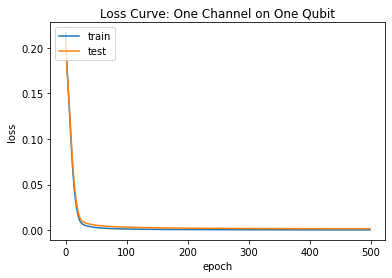

In [96]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Curve: One Channel on One Qubit')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [97]:
score = model.evaluate(x_test,  y_test, verbose=2)

7/7 - 0s - loss: 0.0015 - 275ms/epoch - 39ms/step


In [98]:
#save the model predictions in a tensor
y_prediction = model(x_test)
y_prediction = y_prediction.numpy().tolist()

y_test = tf.cast(y_test, dtype=tf.float32)
x_test = tf.cast(x_test, dtype=tf.float32)


fid = fid_twoq(y_prediction, y_test)

fid_one_mse = tf.math.reduce_mean(fid)
print(fid_one_mse)

tf.Tensor((0.9955662+2.6770262e-05j), shape=(), dtype=complex64)
